In [64]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

In [113]:

# Load the data
population = pd.read_csv("Population.csv")

# Clean column names: lowercase, replace hyphens with underscores
population.columns = (
    population.columns
    .str.lower()
    .str.replace("-", "_")
    .str.replace(" ", "_")
)

# Show cleaned columns
print("Cleaned columns:", population.columns.tolist())

# Confirm data types and nulls (should be fine)
print(population.info())
print(population.isnull().sum())

Cleaned columns: ['sa2_code', 'sa2_name', '0_4_people', '5_9_people', '10_14_people', '15_19_people', '20_24_people', '25_29_people', '30_34_people', '35_39_people', '40_44_people', '45_49_people', '50_54_people', '55_59_people', '60_64_people', '65_69_people', '70_74_people', '75_79_people', '80_84_people', '85_and_over_people', 'total_people']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sa2_code            373 non-null    int64 
 1   sa2_name            373 non-null    object
 2   0_4_people          373 non-null    int64 
 3   5_9_people          373 non-null    int64 
 4   10_14_people        373 non-null    int64 
 5   15_19_people        373 non-null    int64 
 6   20_24_people        373 non-null    int64 
 7   25_29_people        373 non-null    int64 
 8   30_34_people        373 non-null    int64 
 9   35_39_people  

In [115]:
# This loads the POIs from the REST service directly
poi_url = "https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query?where=1%3D1&outFields=*&f=geojson"

pois = gpd.read_file(poi_url)
print(pois.columns)
pois.head()

Index(['objectid', 'topoid', 'poigroup', 'poitype', 'poiname', 'poilabel',
       'poilabeltype', 'poialtlabel', 'poisourcefeatureoid', 'accesscontrol',
       'startdate', 'enddate', 'lastupdate', 'msoid', 'centroidid',
       'shapeuuid', 'changetype', 'processstate', 'urbanity', 'geometry'],
      dtype='object')


,objectid,topoid,poigroup,poitype,poiname,poilabel,poilabeltype,poialtlabel,poisourcefeatureoid,accesscontrol,startdate,enddate,lastupdate,msoid,centroidid,shapeuuid,changetype,processstate,urbanity,geometry
0,1,500000000,9,Mine - Underground,None,Mine - Underground,GENERIC,None,157,1,1628668563000,32503680000000,1628668617000,233046,None,729e2b57-0cd4-3f70-90fa-9dce09e34a8e,I,None,S,POINT (152.12202 -31.10616)
1,2,500005504,3,Lookout,KUNDERANG LOOKOUT,KUNDERANG LOOKOUT,NAMED,None,56,1,1285588392000,32503680000000,1285588392535,83091,None,d88a28a8-c572-3992-995f-d26a274aea18,I,None,S,POINT (152.29869 -31.02148)
2,3,500005505,3,Lookout,FALLS LOOKOUT,FALLS LOOKOUT,NAMED,None,56,1,1285588392000,32503680000000,1285588392535,83691,None,21b476d2-6519-3e28-8b19-1526fcb9652f,I,None,S,POINT (152.33786 -31.01576)
3,4,500005507,3,Lookout,MCCOYS LOOKOUT,MCCOYS LOOKOUT,NAMED,None,56,1,1285588392000,32503680000000,1285588392535,83380,None,016d69b2-6530-39e7-89a6-6e3054df55ac,I,None,S,POINT (152.34181 -31.01897)
4,5,500012781,3,Picnic Area,WILSON RIVER PICNIC AREA,WILSON RIVER PICNIC AREA,NAMED,None,62,1,1608714678000,32503680000000,1608714706360,231054,None,49ad26c8-609e-3aa0-b4ad-51459b43ab51,M,None,S,POINT (152.47882 -31.20754)


In [117]:
# Load stops.txt
stops = pd.read_csv('Stops.txt')

# Preview
stops.head()

# Some cleaning
# Drop rows where stop_lat or stop_lon is missing
stops = stops.dropna(subset=['stop_lat', 'stop_lon'])

# We want to only select the stops inside three areas: 
# Inner West, North Sydney and Hornsby, City and Inner South

# No column name telling which region a stop belongs to
# So: use the stop's latitude and longitude (stop_lat, stop_lon) to filter our disired data

In [119]:
sa2 = gpd.read_filesa2 = gpd.read_file("SA2_2021_AUST_SHP_GDA2020\\SA2_2021_AUST_GDA2020.shp")


print(sa2.columns)
sa2.head()

sa2_sydney = sa2[sa2['GCC_NAME21'] == 'Greater Sydney']

# Create geometry column for stops
stops['geometry'] = stops.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)

# Turn stops into a GeoDataFrame (same CRS)
stops_gdf = gpd.GeoDataFrame(stops, geometry='geometry', crs="EPSG:4283")

stops_gdf = stops_gdf.to_crs(epsg=7844)

stops_with_sa2 = gpd.sjoin(stops_gdf, sa2_sydney, how='left', predicate='within')

# print(stops_with_sa2.head(10)) #debug

target_regions = [
    'Sydney - Inner West',
    'Sydney - North Sydney and Hornsby',
    'Sydney - City and Inner South'
]

filtered_stops = stops_with_sa2[stops_with_sa2['SA4_NAME21'].isin(target_regions)]

filtered_stops = filtered_stops.dropna(subset=['SA4_NAME21'])

columns_to_keep = [
    'stop_id', 'stop_name', 'stop_lat', 'stop_lon',
    'wheelchair_boarding', 'SA2_CODE21', 'SA2_NAME21', 'SA4_NAME21', 'geometry'
]

filtered_stops = filtered_stops[columns_to_keep]

filtered_stops.columns = filtered_stops.columns.str.lower()

filtered_stops.to_csv('s_filtered.csv', index=False)


Index(['SA2_CODE21', 'SA2_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'SA3_CODE21',
       'SA3_NAME21', 'SA4_CODE21', 'SA4_NAME21', 'GCC_CODE21', 'GCC_NAME21',
       'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21',
       'LOCI_URI21', 'geometry'],
      dtype='object')


In [120]:
# Adjust path as needed
catchments_primary = gpd.read_file("catchments\\catchments_primary.shp")

# Preview structure
print(catchments_primary.columns)
catchments_primary.head()

Index(['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'ADD_DATE', 'KINDERGART', 'YEAR1',
       'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9',
       'YEAR10', 'YEAR11', 'YEAR12', 'PRIORITY', 'geometry'],
      dtype='object')


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.92567 -33.7296, 150.92602 -33.72..."
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.15379 -33.75586, 151.15404 -33.7..."


In [121]:
# Adjust path as needed
catchments_secondary = gpd.read_file("catchments\\catchments_secondary.shp")

# Preview structure
print(catchments_secondary.columns)
catchments_secondary.head()

Index(['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'ADD_DATE', 'KINDERGART', 'YEAR1',
       'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9',
       'YEAR10', 'YEAR11', 'YEAR12', 'PRIORITY', 'geometry'],
      dtype='object')


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.67182 -35.31444, 146.6893 -35.31..."
1,8266,HIGH_COED,James Fallon HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((147.08734 -35.86271, 147.10413 -35.8..."
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.81448 -35.78341, 146.8125 -35.79..."
3,8458,HIGH_COED,Kingswood HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"MULTIPOLYGON (((150.686 -33.74031, 150.68631 -..."
4,8559,HIGH_COED,Jamison HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((150.69513 -33.75627, 150.68936 -33.7..."


In [122]:
# Adjust path as needed
catchments_future = gpd.read_file("catchments\\catchments_future.shp")

# Preview structure
print(catchments_future.columns)
catchments_future.head()

Index(['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'ADD_DATE', 'KINDERGART', 'YEAR1',
       'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9',
       'YEAR10', 'YEAR11', 'YEAR12', 'geometry'],
      dtype='object')


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.19849 -33.5399, 151.19945 -33.54..."
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.27152 -33.91402, 151.27152 -33.9..."
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,"POLYGON ((151.15292 -33.83939, 151.16144 -33.8..."
3,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.17794 -33.6982, 151.17859 -33.69..."
4,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.28072 -33.83287, 151.28095 -33.8..."


In [127]:
from sqlalchemy import create_engine, text
import psycopg2
import psycopg2.extras
import json
import os
import pandas as pd

In [129]:


credentials = os.path.expanduser("\\Users\\uwhit\\data2001Tut\\Credentials.json")


def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = "sydney_analysis"  ##### The right database
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [131]:
db, conn = pgconnect(credentials)

Connected successfully.


In [133]:
import geopandas as gpd

# Define shapefile paths
base_path = "\\Users\\uwhit\\DATA2001-A\\catchments"
shapefiles = {
    "catchments_primary": "catchments_primary.shp",
    "catchments_secondary": "catchments_secondary.shp",
    "catchments_future": "catchments_future.shp"
}

# Loop through the catchment files and upload to PGadmin
for table_name, shp_file in shapefiles.items():
    print(f"Processing {table_name}...")
    gdf = gpd.read_file(os.path.expanduser(os.path.join(base_path, shp_file)))
    gdf.columns = [col.lower() for col in gdf.columns]  
    gdf.to_postgis(name=table_name, con=db, if_exists="replace", index=False)
    print(f"✅ Uploaded {table_name} successfully.")

print(f"Using DB: {db.url.database}")

Processing catchments_primary...
✅ Uploaded catchments_primary successfully.
Processing catchments_secondary...
✅ Uploaded catchments_secondary successfully.
Processing catchments_future...
✅ Uploaded catchments_future successfully.
Using DB: sydney_analysis


In [76]:
sa2_path = "SA2_2021_AUST_SHP_GDA2020\\SA2_2021_AUST_GDA2020.shp"
sa2_gdf = gpd.read_file(os.path.expanduser(sa2_path))

#Keep only useful columns
sa2_gdf.columns = [col.lower() for col in sa2_gdf.columns]
columns_to_keep = ["sa2_code21", "sa2_name21", "sa4_name21", "geometry"]
sa2_gdf = sa2_gdf[columns_to_keep]

# Filter rows by target SA4 regions
target_sa4 = [
    "Sydney - Inner West",
    "Sydney - North Sydney and Hornsby",
    "Sydney - City and Inner South"
]
sa2_gdf = sa2_gdf[sa2_gdf["sa4_name21"].isin(target_sa4)]

# SUpload to PostgreSQL
sa2_gdf.to_postgis(name="sa2_regions", con=db, if_exists="replace", index=False)


print(f"✅ Cleaned and uploaded 'sa2_regions' with {len(sa2_gdf)} rows.")
sa2_gdf.head()

✅ Cleaned and uploaded 'sa2_regions' with 74 rows.


,sa2_code21,sa2_name21,sa4_name21,geometry
343,117011320,Banksmeadow,Sydney - City and Inner South,"POLYGON ((151.20807 -33.95405, 151.20817 -33.9..."
344,117011321,Botany,Sydney - City and Inner South,"POLYGON ((151.18965 -33.94813, 151.18919 -33.9..."
345,117011323,Pagewood - Hillsdale - Daceyville,Sydney - City and Inner South,"POLYGON ((151.22312 -33.92869, 151.22189 -33.9..."
346,117011324,Port Botany Industrial,Sydney - City and Inner South,"POLYGON ((151.22091 -33.96895, 151.22066 -33.9..."
347,117011325,Sydney Airport,Sydney - City and Inner South,"POLYGON ((151.17103 -33.927, 151.17167 -33.926..."


In [137]:
# Create geometry column for stops
stops['geometry'] = stops.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)

# Convert to GeoDataFrame with correct CRS
stops_gdf = gpd.GeoDataFrame(stops, geometry='geometry', crs="EPSG:4283")
stops_gdf = stops_gdf.to_crs(epsg=7844)

# Spatial join with Sydney SA2 regions
sa2_path = "SA2_2021_AUST_SHP_GDA2020\\SA2_2021_AUST_GDA2020.shp"
sa2 = gpd.read_file(os.path.expanduser(sa2_path))
sa2_sydney = sa2[sa2['GCC_NAME21'] == 'Greater Sydney']
stops_with_sa2 = gpd.sjoin(stops_gdf, sa2_sydney, how='left', predicate='within')

# Filter by target SA4 regions
target_sa4 = [
    "Sydney - Inner West",
    "Sydney - North Sydney and Hornsby",
    "Sydney - City and Inner South"
]
stops_with_sa2 = stops_with_sa2[stops_with_sa2['SA4_NAME21'].isin(target_sa4)]

# Drop rows without SA4 match
stops_with_sa2 = stops_with_sa2.dropna(subset=['SA4_NAME21'])

# Keep only relevant columns and standardise names
columns_to_keep = [
    'stop_id', 'stop_name', 'stop_lat', 'stop_lon',
    'wheelchair_boarding', 'SA2_CODE21', 'SA2_NAME21', 'SA4_NAME21', 'geometry'
]
stops_with_sa2 = stops_with_sa2[columns_to_keep]
stops_with_sa2.columns = [col.lower() for col in stops_with_sa2.columns]

# Upload to PostgreSQL
stops_with_sa2.to_postgis(name="stops", con=db, if_exists="replace", index=False)

print(f"✅ Cleaned and uploaded 'gtfs_stops' with {len(stops_with_sa2)} rows.")
stops_with_sa2.head()


✅ Cleaned and uploaded 'gtfs_stops' with 8511 rows.


,stop_id,stop_name,stop_lat,stop_lon,wheelchair_boarding,sa2_code21,sa2_name21,sa4_name21,geometry
0,200039,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,0,117031645,Sydney (South) - Haymarket,Sydney - City and Inner South,POINT (151.20667 -33.88219)
1,200054,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,0,117031645,Sydney (South) - Haymarket,Sydney - City and Inner South,POINT (151.207 -33.88203)
2,200060,Central Station,-33.884084,151.206292,0,117031645,Sydney (South) - Haymarket,Sydney - City and Inner South,POINT (151.2063 -33.88407)
3,201510,Redfern Station,-33.891690,151.198866,0,117031642,Redfern,Sydney - City and Inner South,POINT (151.19887 -33.89168)
4,201646,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,0,117031642,Redfern,Sydney - City and Inner South,POINT (151.19889 -33.89332)


# Task 2 - North Sydney & Hornsby

In [139]:
northSydney_gdf = gpd.read_postgis("""
    SELECT *
    FROM sa2_regions
    WHERE sa4_name21 = 'Sydney - North Sydney and Hornsby'
""", conn, geom_col="geometry")

In [141]:
import requests
import io
import geopandas as gpd

def get_pois_from_bbox(minx, miny, maxx, maxy):
    url = "https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query"
    params = {
        "f": "geojson",
        "geometryType": "esriGeometryEnvelope",
        "geometry": f"{minx},{miny},{maxx},{maxy}",
        "spatialRel": "esriSpatialRelIntersects",
        "outFields": "*",
        "inSR": "4283",
        "outSR": "4283"
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        return gpd.read_file(io.StringIO(response.text))
    except Exception as e:
        print(f"❌ Error fetching POIs for bbox {minx},{miny},{maxx},{maxy}:", e)
        return None


In [143]:
import time
from shapely.geometry import shape

all_pois = []

for _, row in northSydney_gdf.iterrows():
    sa2 = row["sa2_name21"]
    minx, miny, maxx, maxy = row["geometry"].bounds
    print(f"📦 Fetching POIs for {sa2}...")
    
    pois = get_pois_from_bbox(minx, miny, maxx, maxy)
    if pois is not None and not pois.empty:
        pois["sa2_name"] = sa2
        all_pois.append(pois)
    
    time.sleep(1)  # be nice to the server


📦 Fetching POIs for Chatswood (West) - Lane Cove North...
📦 Fetching POIs for St Leonards - Naremburn...
📦 Fetching POIs for Artarmon...
📦 Fetching POIs for Castle Cove - Northbridge...
📦 Fetching POIs for Chatswood - East...
📦 Fetching POIs for Greenwich - Riverview...
📦 Fetching POIs for Lane Cove...
📦 Fetching POIs for Willoughby...
📦 Fetching POIs for Asquith - Mount Colah...
📦 Fetching POIs for Berowra - Brooklyn - Cowan...
📦 Fetching POIs for Normanhurst - Thornleigh - Westleigh...
📦 Fetching POIs for Hornsby - East...
📦 Fetching POIs for Hornsby - West...
📦 Fetching POIs for Wahroonga (West) - Waitara...
📦 Fetching POIs for Gordon - Killara...
📦 Fetching POIs for Lindfield - Roseville...
📦 Fetching POIs for Pymble...
📦 Fetching POIs for St Ives...
📦 Fetching POIs for Turramurra...
📦 Fetching POIs for Wahroonga (East) - Warrawee...
📦 Fetching POIs for Cremorne - Cammeray...
📦 Fetching POIs for Crows Nest - Waverton...
📦 Fetching POIs for Neutral Bay - Kirribilli...
📦 Fetching POI

In [144]:
from geopandas import GeoDataFrame

if all_pois:
    all_pois_gdf = gpd.GeoDataFrame(pd.concat(all_pois, ignore_index=True), crs="EPSG:4283")
    all_pois_gdf.to_postgis("pois_northSydney", con=db, if_exists="replace", index=False)
    print(f"✅ Uploaded {len(all_pois_gdf)} POIs.")
else:
    print("⚠️ No POIs collected.")

✅ Uploaded 5650 POIs.


In [145]:
conn.rollback()


# Task 3 - North Sydney & Hornsby

In [173]:
# make sure any earlier error is cleared
conn.rollback()          # <-- this resets the transaction block

sql_stops = """
SELECT sa2_code21,
       sa2_name21,
       COUNT(*) AS n_stops
FROM   stops                 -- ← table you just uploaded
WHERE  sa4_name21 = 'Sydney - North Sydney and Hornsby'
GROUP  BY sa2_code21,
          sa2_name21;
"""

stop_counts = pd.read_sql(sql_stops, conn)
stop_counts.head()


,sa2_code21,sa2_name21,n_stops
0,121011399,Chatswood (West) - Lane Cove North,210
1,121011686,Lane Cove,175
2,121031409,Pymble,283
3,121021406,Normanhurst - Thornleigh - Westleigh,308
4,121041689,Mosman - South,189


In [175]:
northsyd_query = """
SELECT sa2_code21, sa2_name21, geometry
FROM sa2_regions
WHERE sa4_name21 = 'Sydney - North Sydney and Hornsby';
"""

sa2_northsyd = gpd.read_postgis(northsyd_query, conn, geom_col='geometry')
sa2_northsyd.crs = "EPSG:4283"

In [177]:
sql_primary = "SELECT * FROM catchments_primary;"
sql_second = "SELECT * FROM catchments_secondary;"
sql_future = "SELECT * FROM catchments_future;"



In [179]:
primary = gpd.read_postgis(sql_primary, conn, geom_col='geometry')
secondary= gpd.read_postgis(sql_second, conn, geom_col='geometry')
future = gpd.read_postgis(sql_future, conn, geom_col='geometry')

primary["school_type"] = "primary"
secondary["school_type"] = "secondary"
future["school_type"] = "future"

In [181]:
all_schools_combined = pd.concat(
    [primary, secondary, future],
    ignore_index=True
)

schools_sa2 = gpd.sjoin(
    all_schools_combined,
    sa2_northsyd,
    predicate="intersects"
)

In [183]:
school_counts_sa2 = schools_sa2.groupby(
    ["sa2_code21", "sa2_name21", "school_type"]
).size().unstack(fill_value=0).reset_index()

school_counts_sa2["total_schools"] = (
    school_counts_sa2.get("primary", 0) +
    school_counts_sa2.get("secondary", 0) +
    school_counts_sa2.get("future", 0)
)

school_counts_sa2.head()

school_type,sa2_code21,sa2_name21,future,primary,secondary,total_schools
0,121011399,Chatswood (West) - Lane Cove North,0,7,3,10
1,121011401,St Leonards - Naremburn,0,7,4,11
2,121011682,Artarmon,0,6,3,9
3,121011683,Castle Cove - Northbridge,0,4,4,8
4,121011684,Chatswood - East,0,7,5,12


In [205]:
conn.rollback()   

sql_population = """
SELECT 
    "sa2_code",
    "age_5_9",
    "age_10_14",
    "age_15_19"
FROM "populations"
WHERE "sa2_code" IS NOT NULL;
"""

In [207]:
population_youth = pd.read_sql(sql_population, conn)
population_youth["youth_total"] = (
    population_youth["age_5_9"] +
    population_youth["age_10_14"] +
    population_youth["age_15_19"]
)
population_youth.head()

,sa2_code,age_5_9,age_10_14,age_15_19,youth_total
0,102011028,522,623,552,1697
1,102011029,666,702,592,1960
2,102011030,225,258,278,761
3,102011031,804,880,838,2522
4,102011032,1044,1084,1072,3200


In [209]:
population_youth["sa2_code"] = population_youth["sa2_code"].astype(str)
schools_with_youth = school_counts_sa2.merge(
    population_youth,
    left_on="sa2_code21",
    right_on="sa2_code",
    how="left"
)

In [211]:
schools_with_youth["schools_per_1000_youth"] = (
    schools_with_youth["total_schools"] / schools_with_youth["youth_total"]
) * 1000
schools_with_youth.head()

,sa2_code21,sa2_name21,future,primary,secondary,total_schools,sa2_code,age_5_9,age_10_14,age_15_19,youth_total,schools_per_1000_youth
0,121011399,Chatswood (West) - Lane Cove North,0,7,3,10,121011399,1316,1216,950,3482,2.871913
1,121011401,St Leonards - Naremburn,0,7,4,11,121011401,607,451,338,1396,7.879656
2,121011682,Artarmon,0,6,3,9,121011682,765,599,392,1756,5.125285
3,121011683,Castle Cove - Northbridge,0,4,4,8,121011683,959,1228,1077,3264,2.450980
4,121011684,Chatswood - East,0,7,5,12,121011684,1205,1135,974,3314,3.621002


In [235]:
conn.rollback()  

from sqlalchemy import text
sql_business_counts = """
SELECT sa2_code,
       sa2_name,
       SUM(total_businesses) AS n_businesses
FROM "businesses"
WHERE industry_code = 'G'
GROUP BY sa2_code, sa2_name
ORDER BY n_businesses DESC;
"""



In [237]:
business_counts = pd.read_sql_query(text(sql_business_counts), conn)
business_counts.head()

,sa2_code,sa2_name,n_businesses
0,117031644,Sydney (North) - Millers Point,1307
1,199999499,Currently Unknown,537
2,117031645,Sydney (South) - Haymarket,472
3,117031336,Surry Hills,343
4,121011684,Chatswood - East,338


In [241]:

conn.rollback()  
sql_population_total = """
SELECT "sa2_code",
       "total"
FROM "populations"
"""


In [243]:
population_total = pd.read_sql_query(text(sql_population_total), conn)

business_pop = business_counts.merge(
    population_total, on="sa2_code", how="left"
)

business_pop["businesses_per_1000"] = (
    business_pop["n_businesses"] / business_pop["total"]
) * 1000
business_pop.head()

,sa2_code,sa2_name,n_businesses,total,businesses_per_1000
0,117031644,Sydney (North) - Millers Point,1307,8199.0,159.409684
1,199999499,Currently Unknown,537,NaN,NaN
2,117031645,Sydney (South) - Haymarket,472,20346.0,23.198663
3,117031336,Surry Hills,343,16053.0,21.366723
4,121011684,Chatswood - East,338,19770.0,17.096611


In [247]:
sql_park_counts = """
SELECT sa2_name,
       COUNT(*) AS n_parks
FROM "pois_northSydney"
WHERE LOWER(poitype) LIKE '%park%'
   OR LOWER(poilabel) LIKE '%park%'
GROUP BY sa2_name
ORDER BY n_parks DESC;
"""

park_counts = pd.read_sql_query(text(sql_park_counts), conn)
park_counts.head()

,sa2_name,n_parks
0,Turramurra,290
1,Wahroonga (East) - Warrawee,133
2,Lindfield - Roseville,110
3,Gordon - Killara,110
4,Cremorne - Cammeray,100


In [284]:
conn.rollback()  

combined = stop_counts.merge(
    schools_with_youth[["sa2_code", "schools_per_1000_youth"]],
    left_on="sa2_code21", right_on="sa2_code", how="left"
)

combined = combined.merge(
    park_counts.rename(columns={"sa2_name": "sa2_name21"}),
    on="sa2_name21", how="left"
)

combined = combined.merge(
    business_pop.rename(columns={"sa2_name": "sa2_name21"}),
    on="sa2_name21", how="left"
)

combined = combined.rename(columns={
    "n_stops": "stops",
    "schools_per_1000_youth": "schools",
    "n_parks": "parks",
    "businesses_per_1000": "businesses"
})

combined = combined.fillna(0)

combined.head()

,sa2_code21,sa2_name21,stops,sa2_code_x,schools,parks,sa2_code_y,n_businesses,total,businesses
0,121011399,Chatswood (West) - Lane Cove North,210,121011399,2.871913,47,121011399,101,21425.0,4.714119
1,121011686,Lane Cove,175,121011686,2.465657,57,121011686,125,15931.0,7.846337
2,121031409,Pymble,283,121031409,5.154639,97,121031409,109,17262.0,6.314448
3,121021406,Normanhurst - Thornleigh - Westleigh,308,121021406,4.225352,78,121021406,88,19199.0,4.583572
4,121041689,Mosman - South,189,121041689,1.444565,38,121041689,91,14641.0,6.215422


In [286]:
# Compute z-scores
combined["z_stops"] = (combined["stops"] - combined["stops"].mean()) / combined["stops"].std()
combined["z_schools"] = (combined["schools"] - combined["schools"].mean()) / combined["schools"].std()
combined["z_businesses"] = (combined["businesses"] - combined["businesses"].mean()) / combined["businesses"].std()
combined["z_parks"] = (combined["parks"] - combined["parks"].mean()) / combined["parks"].std()

In [288]:
# Total z-score
combined["z_total"] = (
    combined["z_stops"] +
    combined["z_schools"] +
    combined["z_parks"] +
    combined["z_businesses"]
)
combined = combined.drop(columns=["sa2_code_x", "sa2_code_y", "n_businesses", "total"])
combined.head()

,sa2_code21,sa2_name21,stops,schools,parks,businesses,z_stops,z_schools,z_businesses,z_parks,z_total
0,121011399,Chatswood (West) - Lane Cove North,210,2.871913,47,4.714119,0.336344,-0.724164,-0.747959,-0.387961,-1.523740
1,121011686,Lane Cove,175,2.465657,57,7.846337,-0.063752,-0.953973,0.146037,-0.210060,-1.081747
2,121031409,Pymble,283,5.154639,97,6.314448,1.170831,0.567116,-0.291194,0.501544,1.948297
3,121021406,Normanhurst - Thornleigh - Westleigh,308,4.225352,78,4.583572,1.456613,0.041442,-0.785220,0.163532,0.876368
4,121041689,Mosman - South,189,1.444565,38,6.215422,0.096287,-1.531579,-0.319458,-0.548072,-2.302821


In [290]:
import numpy as np
final_scores = combined
final_scores["real_score"] = 1 / (1 + np.exp(-final_scores["z_total"]))
final_scores = final_scores.reset_index(drop=True)
final_scores

,sa2_code21,sa2_name21,stops,schools,parks,businesses,z_stops,z_schools,z_businesses,z_parks,z_total,real_score
0,121011399,Chatswood (West) - Lane Cove North,210,2.871913,47,4.714119,0.336344,-0.724164,-0.747959,-0.387961,-1.523740,0.178911
1,121011686,Lane Cove,175,2.465657,57,7.846337,-0.063752,-0.953973,0.146037,-0.210060,-1.081747,0.253176
2,121031409,Pymble,283,5.154639,97,6.314448,1.170831,0.567116,-0.291194,0.501544,1.948297,0.875261
3,121021406,Normanhurst - Thornleigh - Westleigh,308,4.225352,78,4.583572,1.456613,0.041442,-0.785220,0.163532,0.876368,0.706069
4,121041689,Mosman - South,189,1.444565,38,6.215422,0.096287,-1.531579,-0.319458,-0.548072,-2.302821,0.090890
5,121031410,St Ives,256,3.618818,98,6.981123,0.862185,-0.301659,-0.100912,0.519334,0.978948,0.726899
6,121011682,Artarmon,35,5.125285,15,4.224311,-1.664136,0.550511,-0.887760,-0.957244,-2.958629,0.049330
7,121011684,Chatswood - East,144,3.621002,28,17.096611,-0.418122,-0.300424,2.786247,-0.725973,1.341728,0.792774
8,121011401,St Leonards - Naremburn,43,7.879656,27,13.348907,-1.572685,2.108589,1.716579,-0.743763,1.508719,0.818871
9,121021403,Asquith - Mount Colah,368,3.847798,69,4.066143,2.142492,-0.172131,-0.932904,0.003421,1.040879,0.739020


In [292]:
#Task 4

In [294]:
final_scores.sort_values("real_score", ascending=False)

,sa2_code21,sa2_name21,stops,schools,parks,businesses,z_stops,z_schools,z_businesses,z_parks,z_total,real_score
23,121031411,Turramurra,273,6.076186,290,6.003642,1.056517,1.088412,-0.379904,3.935033,5.700058,0.996665
2,121031409,Pymble,283,5.154639,97,6.314448,1.170831,0.567116,-0.291194,0.501544,1.948297,0.875261
8,121011401,St Leonards - Naremburn,43,7.879656,27,13.348907,-1.572685,2.108589,1.716579,-0.743763,1.508719,0.818871
14,121031407,Gordon - Killara,194,4.534213,110,8.587110,0.153443,0.216157,0.357469,0.732815,1.459884,0.811515
7,121011684,Chatswood - East,144,3.621002,28,17.096611,-0.418122,-0.300424,2.786247,-0.725973,1.341728,0.792774
22,121041417,North Sydney - Lavender Bay,121,3.613369,53,16.298299,-0.681043,-0.304741,2.558393,-0.281220,1.291389,0.784382
21,121031412,Wahroonga (East) - Warrawee,239,4.054376,133,5.426442,0.667853,-0.055275,-0.544648,1.141987,1.209917,0.770284
17,121021577,Hornsby - East,71,8.338679,30,9.834972,-1.252608,2.368246,0.713633,-0.690393,1.138878,0.757474
13,121031408,Lindfield - Roseville,329,2.299257,110,6.382807,1.696671,-1.048101,-0.271683,0.732815,1.109702,0.752074
9,121021403,Asquith - Mount Colah,368,3.847798,69,4.066143,2.142492,-0.172131,-0.932904,0.003421,1.040879,0.739020


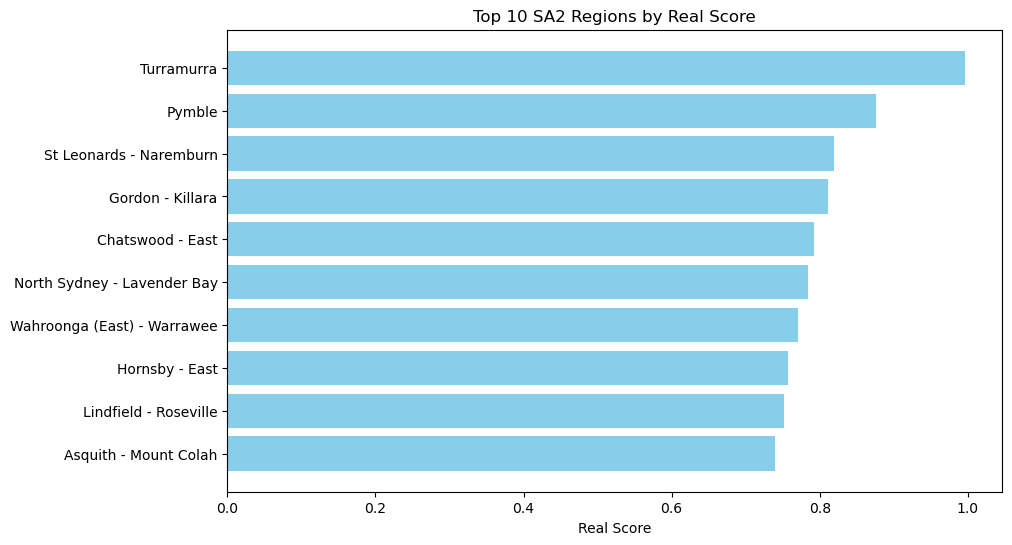

In [296]:
import matplotlib.pyplot as plt

# Bar chart: top 10 regions
top10 = final_scores.sort_values("real_score", ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(top10["sa2_name21"], top10["real_score"], color="skyblue")
plt.xlabel("Real Score")
plt.title("Top 10 SA2 Regions by Real Score")
plt.gca().invert_yaxis()
plt.show()

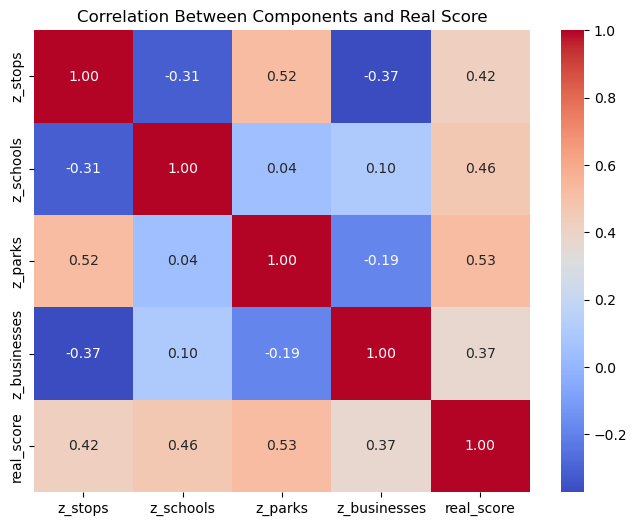

In [298]:
import seaborn as sns

# Correlation matrix between z components and real score
score_corr = final_scores[["z_stops", "z_schools", "z_parks", "z_businesses", "real_score"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(score_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Components and Real Score")
plt.show()

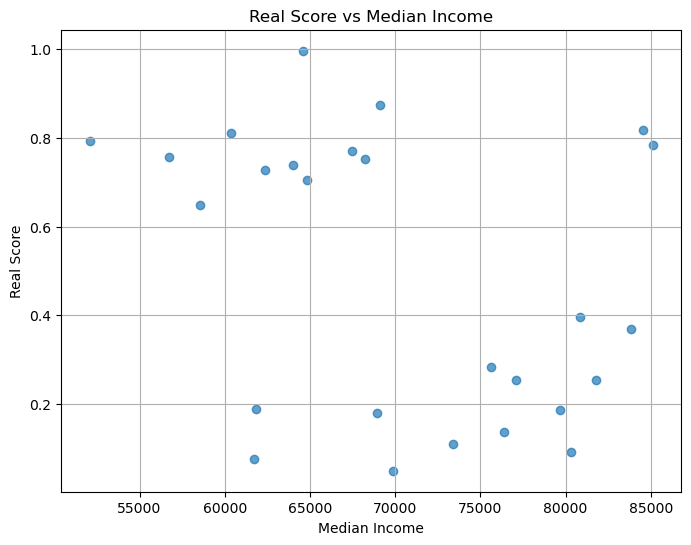

correlation coeffient: -0.3500356828916123


In [300]:
income = pd.read_csv("i_cleaned.csv")

final_scores["sa2_code21"] = final_scores["sa2_code21"].astype(str)
income["sa2_code"] = income["sa2_code"].astype(str)

income_joined = final_scores.merge(income, left_on="sa2_code21", right_on="sa2_code", how="left")

import matplotlib.pyplot as plt
# Scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(income_joined["median_income"], income_joined["real_score"], alpha=0.7)
plt.xlabel("Median Income")
plt.ylabel("Real Score")
plt.title("Real Score vs Median Income")
plt.grid(True)
plt.show()

# Correlation coefficient
income_corr = income_joined["real_score"].corr(income_joined["median_income"])
print("correlation coeffient:", income_corr)

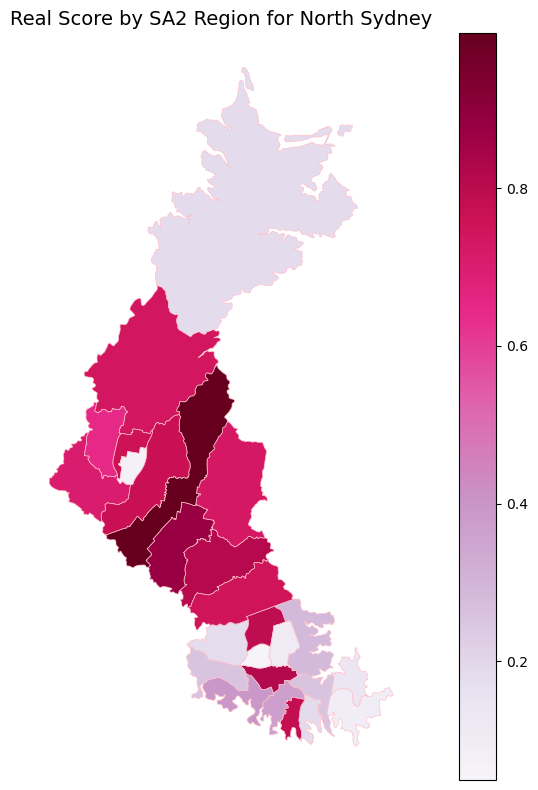

In [302]:
map_visual = northSydney_gdf.merge(final_scores, on="sa2_code21", how="left")
fig, ax = plt.subplots(figsize=(10, 8))
map_visual.plot(
    column="real_score",
    cmap="PuRd",
    linewidth=0.5,
    edgecolor="pink",
    legend=True,
    ax=ax
)
ax.set_title("Real Score by SA2 Region for North Sydney", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()